In [1]:
import sys
sys.path.insert(1, '../custom_modules')

In [2]:
#create config
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 256  # TODO: the generated image resolution
    channels = 1 
    train_batch_size = 4
    eval_batch_size = 4
    num_epochs = 90 #600 # one epoch needs ~12min (x2 GPU)
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 100 #500
    evaluate_epochs = 20
    evaluate_num_batches = 20 # one batch needs ~15s.  
    evaluate_3D_epochs = 1000  # one 3D evaluation needs ~20min
    save_model_epochs = 60
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "lesion-filling-256-cond-lesions"  # the model name locally and on the HF Hub
    dataset_train_path = "./dataset_train/imgs"
    segm_train_path = "./dataset_train/segm"
    masks_train_path = "./dataset_train/masks"
    dataset_eval_path = "./dataset_eval/imgs"
    segm_eval_path = "./dataset_eval/segm"
    masks_eval_path = "./dataset_eval/masks" 
    train_only_connected_masks=True
    eval_only_connected_masks=False
    num_inference_steps=50
    mode = "train" # train / eval
    debug = True 

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    #hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    #hub_private_repo = False
    #overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
config = TrainingConfig()

In [3]:
if config.debug:
    config.num_inference_steps=5
    config.train_batch_size = 1
    config.eval_batch_size = 1 
    config.train_only_connected_masks=False
    config.eval_only_connected_masks=False
    config.evaluate_num_batches=1
    dataset_train_path = "./dataset_eval/imgs"
    segm_train_path = "./dataset_eval/segm"
    masks_train_path = "./dataset_eval/masks" 

In [4]:
#setup huggingface accelerate
import torch
import numpy as np
import accelerate
accelerate.commands.config.default.write_basic_config(config.mixed_precision)
#if there are problems with ports then add manually "main_process_port: 0" or another number to yaml file

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [5]:
from DatasetMRI2D import DatasetMRI2D
from DatasetMRI3D import DatasetMRI3D
from pathlib import Path

#create dataset
datasetTrain = DatasetMRI2D(Path(config.dataset_train_path), Path(config.segm_train_path), Path(config.masks_train_path), only_connected_masks=config.train_only_connected_masks)
datasetEvaluation = DatasetMRI2D(Path(config.dataset_eval_path), Path(config.segm_eval_path), Path(config.masks_eval_path), only_connected_masks=config.eval_only_connected_masks)
dataset3DEvaluation = DatasetMRI3D(Path(config.dataset_eval_path), Path(config.segm_eval_path), Path(config.masks_eval_path), only_connected_masks=config.eval_only_connected_masks)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

### Visualize dataset

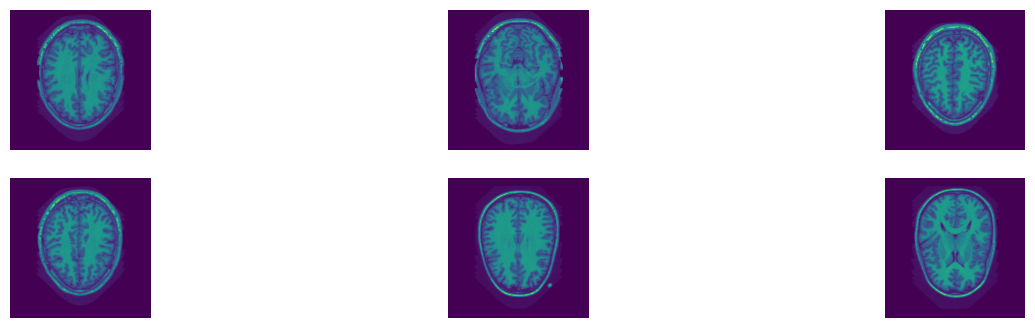

In [6]:
import matplotlib.pyplot as plt

# Get 6 random sample
random_indices = np.random.randint(0, len(datasetTrain) - 1, size=(6)) 

# Plot: t1n images
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow((datasetTrain[idx]["gt_image"].squeeze()+1)/2)
    axis[i//3,i%3].set_axis_off()
fig.show()

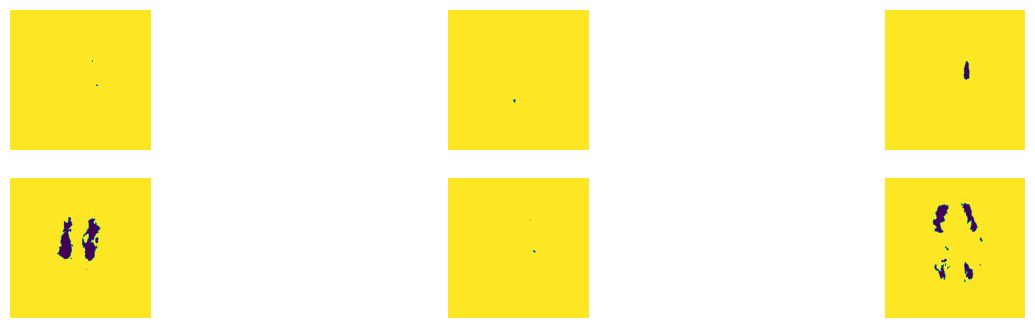

In [7]:
# Plot: masks
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow(datasetTrain[idx]["mask"].squeeze())
    axis[i//3,i%3].set_axis_off()
fig.show()

### Prepare Training

In [8]:
"""
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import random

#reset seed every time a worker loads a dataset 
def reset_seed(worker_id=0): 
    np.random.seed(config.seed) 
    torch.manual_seed(config.seed)
    torch.cuda.manual_seed_all(config.seed)
    random.seed(config.seed)
    return

# create dataloader function, which is executed inside the training loop (necessary because of huggingface accelerate)
def get_dataloader(dataset, batch_size, num_workers=4, random_sampler=False): 
    sampler = RandomSampler(dataset, generator=(None if random_sampler else torch.cuda.manual_seed_all(config.seed)))
    return DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=sampler, worker_init_fn=(None if random_sampler else reset_seed))
"""

'\nfrom torch.utils.data import DataLoader\nfrom torch.utils.data import RandomSampler\nimport random\n\n#reset seed every time a worker loads a dataset \ndef reset_seed(worker_id=0): \n    np.random.seed(config.seed) \n    torch.manual_seed(config.seed)\n    torch.cuda.manual_seed_all(config.seed)\n    random.seed(config.seed)\n    return\n\n# create dataloader function, which is executed inside the training loop (necessary because of huggingface accelerate)\ndef get_dataloader(dataset, batch_size, num_workers=4, random_sampler=False): \n    sampler = RandomSampler(dataset, generator=(None if random_sampler else torch.cuda.manual_seed_all(config.seed)))\n    return DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=sampler, worker_init_fn=(None if random_sampler else reset_seed))\n'

In [9]:
#create model
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3, # the number of input channels: 1 for img, 1 for img_voided, 1 for mask
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

config.model = "UNet2DModel"

In [10]:
#setup noise scheduler
import torch
from PIL import Image
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
#sample_image = datasetTrain[0]['gt_image'].unsqueeze(0)
#noise = torch.randn(sample_image.shape)
#timesteps = torch.LongTensor([50])
#noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

config.noise_scheduler = "DDIMScheduler(num_train_timesteps=1000)"

In [11]:
# setup lr scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(math.ceil(len(datasetTrain)/config.train_batch_size) * config.num_epochs), # num_iterations per epoch * num_epochs
)

config.lr_scheduler = "cosine_schedule_with_warmup"

In [12]:
"""
def meta_logs(tb_summary):
    #log at tensorboard
    tb_summary.add_scalar("image_size", config.image_size, 0)
    tb_summary.add_scalar("train_batch_size", config.train_batch_size, 0)
    tb_summary.add_scalar("eval_batch_size", config.eval_batch_size, 0)
    tb_summary.add_scalar("num_epochs", config.num_epochs, 0)
    tb_summary.add_scalar("learning_rate", config.learning_rate, 0)
    tb_summary.add_scalar("lr_warmup_steps", config.lr_warmup_steps, 0)
    tb_summary.add_scalar("evaluate_epochs", config.evaluate_epochs, 0)
    tb_summary.add_scalar("evaluate_save_img_epochs", config.evaluate_save_img_epochs, 0)
    tb_summary.add_scalar("evaluate_3D_epochs", config.evaluate_3D_epochs, 0) 
    tb_summary.add_text("mixed_precision", config.mixed_precision, 0) 
    tb_summary.add_scalar("train_only_connected_masks", config.train_only_connected_masks, 0)
    tb_summary.add_scalar("eval_only_connected_masks", config.eval_only_connected_masks, 0) 
    tb_summary.add_scalar("debug", config.debug, 0) 
    tb_summary.add_text("mode", config.mode, 0) 
    tb_summary.add_text("conditional_data", "Lesions", 0) 
    tb_summary.add_text("noise_scheduler", "DDIMScheduler(num_train_timesteps=1000)", 0) 
    tb_summary.add_text("lr_scheduler", "cosine_schedule_with_warmup", 0)
    tb_summary.add_text("model", "UNet2DModel", 0) 
    tb_summary.add_text("inference_pipeline", "DDIMPipeline", 0)   
"""

'\ndef meta_logs(tb_summary):\n    #log at tensorboard\n    tb_summary.add_scalar("image_size", config.image_size, 0)\n    tb_summary.add_scalar("train_batch_size", config.train_batch_size, 0)\n    tb_summary.add_scalar("eval_batch_size", config.eval_batch_size, 0)\n    tb_summary.add_scalar("num_epochs", config.num_epochs, 0)\n    tb_summary.add_scalar("learning_rate", config.learning_rate, 0)\n    tb_summary.add_scalar("lr_warmup_steps", config.lr_warmup_steps, 0)\n    tb_summary.add_scalar("evaluate_epochs", config.evaluate_epochs, 0)\n    tb_summary.add_scalar("evaluate_save_img_epochs", config.evaluate_save_img_epochs, 0)\n    tb_summary.add_scalar("evaluate_3D_epochs", config.evaluate_3D_epochs, 0) \n    tb_summary.add_text("mixed_precision", config.mixed_precision, 0) \n    tb_summary.add_scalar("train_only_connected_masks", config.train_only_connected_masks, 0)\n    tb_summary.add_scalar("eval_only_connected_masks", config.eval_only_connected_masks, 0) \n    tb_summary.add_scal

In [13]:
"""
#import custom modules
from DDIMInpaintPipeline import DDIMInpaintPipeline
from Evaluation2D import Evaluation2D
from Evaluation3D import Evaluation3D

#import other modules
from torch.utils.tensorboard import SummaryWriter
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os 
import torch.nn as nn 
import torch.nn.functional as F
import sys
import time

def train_loop(config, model, noise_scheduler, optimizer, lr_scheduler):
    # setup training environment
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        project_dir=os.path.join(config.output_dir, "tensorboard"),
    )

    if accelerator.is_main_process:
        #setup tensorboard
        tb_summary = SummaryWriter(config.output_dir, purge_step=0)
        meta_logs(tb_summary)
        
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True) 
        accelerator.init_trackers("train_example")

    train_dataloader = get_dataloader(dataset = datasetTrain, batch_size = config.train_batch_size, random_sampler=True)
    d2_eval_dataloader = get_dataloader(dataset = datasetEvaluation, batch_size = config.eval_batch_size, random_sampler=False)
    d3_eval_dataloader = get_dataloader(dataset = dataset3DEvaluation, batch_size = 1, random_sampler=False) 

    model, optimizer, train_dataloader, d2_eval_dataloader, d3_eval_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, d2_eval_dataloader, d3_eval_dataloader, lr_scheduler
    )
    
    os.makedirs(config.output_dir, exist_ok=True)  

    global_step = 0

    #Test eval functions at the beginning of training
    #if accelerator.is_main_process:
    #    epoch=0
    #    model.eval()
    #    pipeline = DDIMInpaintPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)  
    #    evaluate(config, epoch, pipeline, d2_eval_dataloader, global_step, tb_summary)
    #    dim3evaluate(config, epoch, pipeline, d3_eval_dataloader, global_step, tb_summary)
    
    
    # Train model
    model.train()
    for epoch in range(config.num_epochs): 
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process) 
        progress_bar.set_description(f"Epoch {epoch}") 
        
        for step, batch in enumerate(train_dataloader): 
            
            clean_images = batch["gt_image"]
            masks = batch["mask"] 
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )
            
            #create voided img
            voided_images = clean_images*masks

            # Add noise to the voided images according to the noise magnitude at each timestep (forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps) 

            # concatenate noisy_images, voided_images and mask
            input=torch.cat((noisy_images, voided_images, masks), dim=1)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(input, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
    
                #log gradient norm 
                parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
                if len(parameters) == 0:
                    total_norm = 0.0
                else: 
                    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).cpu() for p in parameters]), 2.0).item()

                #do learning step
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)

            # save logs
            if accelerator.is_main_process:
                logs = {"loss": loss.cpu().detach().item(), "lr": lr_scheduler.get_last_lr()[0], "total_norm": total_norm, "step": global_step}
                tb_summary.add_scalar("loss", logs["loss"], global_step)
                tb_summary.add_scalar("lr", logs["lr"], global_step) 
                tb_summary.add_scalar("total_norm", logs["total_norm"], global_step) 
            
                progress_bar.set_postfix(**logs)
                #accelerator.log(logs, step=global_step)
            global_step += 1 

            if config.debug:
                break

        # After a certain number of epochs it does the evaluation and save the model
        model.eval()
        pipeline = DDIMInpaintPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
        pipeline = accelerator.prepare(pipeline)

        if (epoch) % config.evaluate_epochs == 0 or epoch == config.num_epochs - 1: 
            eval = Evaluation2D(config, pipeline, d2_eval_dataloader, None if not accelerator.is_main_process else tb_summary, accelerator)
            eval.evaluate(epoch, global_step)

        if (epoch) % config.evaluate_3D_epochs == 0 or epoch == config.num_epochs - 1: 
            eval = Evaluation3D(config, pipeline, d3_eval_dataloader)  
            eval.evaluate(epoch)
    
        if accelerator.is_main_process:
            if (epoch) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1: 
                pipeline.save_pretrained(config.output_dir)
"""

'\n#import custom modules\nfrom DDIMInpaintPipeline import DDIMInpaintPipeline\nfrom Evaluation2D import Evaluation2D\nfrom Evaluation3D import Evaluation3D\n\n#import other modules\nfrom torch.utils.tensorboard import SummaryWriter\nfrom accelerate import Accelerator\nfrom huggingface_hub import create_repo, upload_folder\nfrom tqdm.auto import tqdm\nfrom pathlib import Path\nimport os \nimport torch.nn as nn \nimport torch.nn.functional as F\nimport sys\nimport time\n\ndef train_loop(config, model, noise_scheduler, optimizer, lr_scheduler):\n    # setup training environment\n    accelerator = Accelerator(\n        mixed_precision=config.mixed_precision,\n        gradient_accumulation_steps=config.gradient_accumulation_steps, \n        project_dir=os.path.join(config.output_dir, "tensorboard"),\n    )\n\n    if accelerator.is_main_process:\n        #setup tensorboard\n        tb_summary = SummaryWriter(config.output_dir, purge_step=0)\n        meta_logs(tb_summary)\n        \n        

In [14]:
"""args = {"config": config, "model": model, "noise_scheduler": noise_scheduler, "optimizer": optimizer, "lr_scheduler": lr_scheduler} 
if config.mode == "train":
    train_loop(**args)
"""

'args = {"config": config, "model": model, "noise_scheduler": noise_scheduler, "optimizer": optimizer, "lr_scheduler": lr_scheduler} \nif config.mode == "train":\n    train_loop(**args)\n'

In [15]:
"""
# for 4 patient with 1 mask it takes ~13 min + ~18 min segmentation algorithm
if config.mode == "eval":
    # initialize accelerator, pipeline and tensorboard
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        project_dir=os.path.join(config.output_dir, "tensorboard"),
    )
    pipeline = DDIMInpaintPipeline.from_pretrained(config.output_dir) 
    if accelerator.is_main_process:
        #setup tensorboard
        tb_summary = SummaryWriter(config.output_dir, purge_step=0)
        meta_logs(tb_summary)
        
    # setup dataloaders
    d2_eval_dataloader = get_dataloader(dataset = datasetEvaluation, batch_size = config.eval_batch_size, random_sampler=False)
    d3_eval_dataloader = get_dataloader(dataset = dataset3DEvaluation, batch_size = 1, random_sampler=False)

    # move devices to gpu/cpu
    pipeline, d2_eval_dataloader, d3_eval_dataloader = accelerator.prepare(pipeline, d2_eval_dataloader, d3_eval_dataloader)
    pipeline.to(accelerator.device)

    # start evaluation
    eval = Evaluation2D(config, pipeline, d2_eval_dataloader, None if not accelerator.is_main_process else tb_summary, accelerator)
    eval.evaluate(epoch=0, global_step=0)
    eval = Evaluation3D(config, pipeline, d3_eval_dataloader)
    eval.evaluate(epoch=0)
"""

'\n# for 4 patient with 1 mask it takes ~13 min + ~18 min segmentation algorithm\nif config.mode == "eval":\n    # initialize accelerator, pipeline and tensorboard\n    accelerator = Accelerator(\n        mixed_precision=config.mixed_precision,\n        gradient_accumulation_steps=config.gradient_accumulation_steps, \n        project_dir=os.path.join(config.output_dir, "tensorboard"),\n    )\n    pipeline = DDIMInpaintPipeline.from_pretrained(config.output_dir) \n    if accelerator.is_main_process:\n        #setup tensorboard\n        tb_summary = SummaryWriter(config.output_dir, purge_step=0)\n        meta_logs(tb_summary)\n        \n    # setup dataloaders\n    d2_eval_dataloader = get_dataloader(dataset = datasetEvaluation, batch_size = config.eval_batch_size, random_sampler=False)\n    d3_eval_dataloader = get_dataloader(dataset = dataset3DEvaluation, batch_size = 1, random_sampler=False)\n\n    # move devices to gpu/cpu\n    pipeline, d2_eval_dataloader, d3_eval_dataloader = accel

In [16]:
from TrainingConditional import TrainingConditional
from DDIMInpaintPipeline import DDIMInpaintPipeline

config.conditional_data = "Lesions"

args = {"config": config, "model": model, "noise_scheduler": noise_scheduler, "optimizer": optimizer, "lr_scheduler": lr_scheduler, "datasetTrain": datasetTrain, "datasetEvaluation": datasetEvaluation, "dataset3DEvaluation": dataset3DEvaluation, "trainingCircularMasks": False} 
trainingLesions = TrainingConditional(**args)


2024-03-29 13:46:48.220687: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 13:46:48.302144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 13:46:48.302195: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 13:46:48.302231: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 13:46:48.313621: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 13:46:48.314626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [17]:
if config.mode == "train":
    trainingLesions.train()

  0%|          | 0/2047 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

SSIM_global:  -0.007934803143143654
PSNR_global:  3.321906328201294
MSE_global:  1.8615271756303817
global_step:  1
image saved


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f634680d620>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1438, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1386, in _mark_worker_as_unavailable
    q.put(None)
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 94, in put
    self._start_thread()
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 177, in _start_thread
    self._thread.start()
  File "/opt/conda/lib/python3.11/threading.py", line 969, in start
    self._started.wait()
  File "/opt/conda/lib/python3.11/threading.py", line 629, in wait
    signaled = self._cond.wait(timeout)
           

KeyboardInterrupt: 

In [ ]:
if config.mode == "eval":
    pipeline = DDIMInpaintPipeline.from_pretrained(config.output_dir) 
    trainingLesions.evaluate(pipeline)

In [ ]:
print("Finished Training")

In [18]:
#create python script for ubelix
!jupyter nbconvert --to script "lesion_filling_conditioned_lesions.ipynb"
filename="lesion_filling_conditioned_lesions.py"

# delete this cell from python file
lines = []
with open(filename, 'r') as fp:
    lines = fp.readlines()
with open(filename, 'w') as fp:
    for number, line in enumerate(lines):
        if number < len(lines)-18: 
            fp.write(line)
# Deactivate Debug!!!

[NbConvertApp] Converting notebook lesion_filling_conditioned_lesions.ipynb to script
[NbConvertApp] Writing 16455 bytes to lesion_filling_conditioned_lesions.py
